# Recruit Restaurant Visitor Forecasting

1. Business Probelm

1.1 Description 

What if a restaurant owner gets an exact prediction that tomorrow his/her restaurant will get around 60 customers. Now they have the number of customers, it became very easy for the restaurant people to buy the accurate ingredients and to prepare food to the exact quantity which will fit 60 customers. It instantly saves time and money.

But these kind of forecasting is not trivial, it includes lot of factors like holidays, weekends, weather, country situation. It may be easy for the resaturants which are there for long time because we can use the history of visitors, but may be trivial not for new restaurants.

Credits: Kaggle

Problem statement.
1. We are challenged to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates.
2. This information will help the restaurants improve their quality of service.

1.2 Sources/Useful Links

Source : https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting

Useful Links and kaggle submissions:
1. Most voted: https://www.kaggle.com/headsortails/be-my-guest-recruit-restaurant-eda
2. 1st place solution: https://www.kaggle.com/pureheart/1st-place-lgb-model-public-0-470-private-0-502
3. A trick to improve score: https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/49100
4. kaggle submission: https://www.kaggle.com/pureheart/1st-place-lgb-model-public-0-470-private-0-502
5. kaggle submission: https://www.kaggle.com/festa78/simple-xgboost-lb-0-495


1.3 Real world/Business Objectives and Constraints

1. The cost of misprediction can be high, especially if underpredicted.
2. No latency concerns.
3. Interpretability is important.

2.Mapping the real world problem to an ML problem

  2.1 Type of Machine Leaning Problem

     It is a regression problem where we have to preidct a quantity of visitors for a restaurant.

2.2 Performance Metric

Source: https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/overview/evaluation

Submissions are evaluated on the root mean squared logarithmic error.

The RMSLE is calculated as:
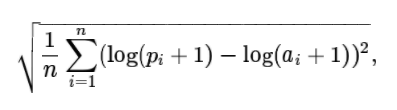

p-predicted, a-actual

Why this metric? (Ref-https://www.youtube.com/watch?v=6llLC4M3dMo)
1. Suppose,
    true=100, predicted=70(if we compare with Root mean squared error)
    
    RMSE:30  RMLSE:0.0234
    
    true=100  predicted=130
    
    RMSE:30  RMLSE:0.0137

• RMLSE penalizes more if visitors are under predicted, the restaurants prefer to be over prepared.
2. true=1000, predicted=1500

   RMSE:500   RMSLE:0.0310
   
   true=10000, predicted=100500
   
   RMSE:500   RMSLE:0.00000467
   
• If over predicted RMSLE penalizes less to the restaurants which has higher capacity than the restaurants which have lower capacity.


2.3 Train and Test Split

Source: https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data 

This is a time series forecasting problem.

Training data: The training data covers the dates from 2016 until April 2017.

Test data: The test set covers the last week of April and May of 2017.

In [1]:
# importing all the required libraries
import numpy as np
import pandas as pd
from datetime import datetime
import time, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

# Data Overview

In [2]:
# Reading all the files

air_visit_data = pd.read_csv('air_visit_data.csv')
air_store_info = pd.read_csv('air_store_info.csv')
air_reserve = pd.read_csv('air_reserve.csv')
hpg_store_info = pd.read_csv('hpg_store_info.csv')
hpg_reserve = pd.read_csv('hpg_reserve.csv')
date_info = pd.read_csv('date_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [25]:
# This is the main dataset which consists of the total visitors for the restaurants.
print("Shape of air_visit_data.csv: ",air_visit_data.shape)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(air_visit_data.info())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
air_visit_data.head()

Shape of air_visit_data.csv:  (252108, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.8+ MB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
1  air_ba937bf13d40fb24  2016-01-14        32
2  air_ba937bf13d40fb24  2016-01-15        29
3  air_ba937bf13d40fb24  2016-01-16        22
4  air_ba937bf13d40fb24  2016-01-18         6

In [26]:
# This dataset gives us information about restaurants which are registered in AirREGI.
print("Shape of air_store_info.csv: ",air_store_info.shape)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(air_store_info.info())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
air_store_info.head()

Shape of air_store_info.csv:  (829, 5)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
2  air_fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
3  air_a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
4  air_83db5aff8f50478e  Italian/French  Tōkyō-to Minato-ku Shibakōen   

    latitude   longitude  
0  34.695124  135.197852  
1  34.695124  135.197852  
2  34.695124  135.197852  
3  34.695124  135.197852  
4  35.658068  139.751599

In [27]:
# This dataset consists of the information about the reservation time and visit time of the customers in AirREGI..
print("Shape of air_reserve.csv: ",air_reserve.shape)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(air_reserve.info())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
air_reserve.head()

Shape of air_reserve.csv:  (92378, 4)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null object
reserve_datetime    92378 non-null object
reserve_visitors    92378 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.8+ MB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


air_store_id       visit_datetime     reserve_datetime  \
0  air_877f79706adbfb06  2016-01-01 19:00:00  2016-01-01 16:00:00   
1  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00   
2  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00   
3  air_877f79706adbfb06  2016-01-01 20:00:00  2016-01-01 16:00:00   
4  air_db80363d35f10926  2016-01-01 20:00:00  2016-01-01 01:00:00   

   reserve_visitors  
0                 1  
1                 3  
2                 6  
3                 2  
4                 5

In [29]:
# This dataset gives us information about restaurants which are registered in Hot Pepper Gourmet (hpg).
print("Shape of hpg_store_info.csv: ",hpg_store_info.shape)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(hpg_store_info.info())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
hpg_store_info.head()

Shape of hpg_store_info.csv:  (4690, 5)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
hpg_store_id      4690 non-null object
hpg_genre_name    4690 non-null object
hpg_area_name     4690 non-null object
latitude          4690 non-null float64
longitude         4690 non-null float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


hpg_store_id  hpg_genre_name                  hpg_area_name  \
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
1  hpg_e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
2  hpg_2976f7acb4b3a3bc  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
3  hpg_e51a522e098f024c  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
4  hpg_e3d0e1519894f275  Japanese style  Tōkyō-to Setagaya-ku Taishidō   

    latitude   longitude  
0  35.643675  139.668221  
1  35.643675  139.668221  
2  35.643675  139.668221  
3  35.643675  139.668221  
4  35.643675  139.668221

In [30]:
# This dataset consists of the information about the reservation time and visit time of the customers in Hot Pepper Gourmet (hpg).
print("Shape of hpg_reserve.csv: ",hpg_reserve.shape)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(hpg_reserve.info())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
hpg_reserve.head()

Shape of hpg_reserve.csv:  (2000320, 4)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors    int64
dtypes: int64(1), object(3)
memory usage: 61.0+ MB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


hpg_store_id       visit_datetime     reserve_datetime  \
0  hpg_c63f6f42e088e50f  2016-01-01 11:00:00  2016-01-01 09:00:00   
1  hpg_dac72789163a3f47  2016-01-01 13:00:00  2016-01-01 06:00:00   
2  hpg_c8e24dcf51ca1eb5  2016-01-01 16:00:00  2016-01-01 14:00:00   
3  hpg_24bb207e5fd49d4a  2016-01-01 17:00:00  2016-01-01 11:00:00   
4  hpg_25291c542ebb3bc2  2016-01-01 17:00:00  2016-01-01 03:00:00   

   reserve_visitors  
0                 1  
1                 3  
2                 2  
3                 5  
4                13

In [31]:
# This dataset gives information about which particular dates are holidays.
# Holiday-1, Non holiday-0
print("Shape of date_info.csv: ",date_info.shape)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(date_info.info())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
date_info.head()

Shape of date_info.csv:  (517, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
calendar_date    517 non-null object
day_of_week      517 non-null object
holiday_flg      517 non-null int64
dtypes: int64(1), object(2)
memory usage: 12.2+ KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


calendar_date day_of_week  holiday_flg
0    2016-01-01      Friday            1
1    2016-01-02    Saturday            1
2    2016-01-03      Sunday            1
3    2016-01-04      Monday            0
4    2016-01-05     Tuesday            0

In [32]:
# This dataset gives the relation between the ids of AirREGI and Hot Pepper Gourmet data for each restaurants.
# for a single restaurant there is a unique AirREGI id and a unique Hot Pepper Gourmet id.
print("Shape of store_id_relation.csv: ",store_id_relation.shape)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(store_id_relation.info())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
store_id_relation.head()

Shape of store_id_relation.csv:  (150, 2)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
air_store_id    150 non-null object
hpg_store_id    150 non-null object
dtypes: object(2)
memory usage: 2.4+ KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


air_store_id          hpg_store_id
0  air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
1  air_a24bf50c3e90d583  hpg_c34b496d0305a809
2  air_c7f78b4f3cba33ff  hpg_cd8ae0d9bbd58ff9
3  air_947eb2cae4f3e8f2  hpg_de24ea49dc25d6b8
4  air_965b2e0cf4119003  hpg_653238a84804d8e7

In [33]:
# This dataset is basically a test dataset without the labels i.e. the number of visitors.
print("Shape of sample_submission.csv: ",sample_submission.shape)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(sample_submission.info())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
sample_submission.head()

Shape of sample_submission.csv:  (32019, 2)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 2 columns):
id          32019 non-null object
visitors    32019 non-null int64
dtypes: int64(1), object(1)
memory usage: 500.4+ KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


id  visitors
0  air_00a91d42b08b08d9_2017-04-23         0
1  air_00a91d42b08b08d9_2017-04-24         0
2  air_00a91d42b08b08d9_2017-04-25         0
3  air_00a91d42b08b08d9_2017-04-26         0
4  air_00a91d42b08b08d9_2017-04-27         0

Code References:

1. https://www.kaggle.com/peeyushsahu/visitorforecast-nn-rt

2. https://www.kaggle.com/headsortails/be-my-guest-recruit-restaurant-eda

3. https://www.kaggle.com/festa78/simple-xgboost-lb-0-495

4. https://www.kaggle.com/h54k3y/my-first-challenge-of-ensemble-learning


## Exploratory Data Analysis.


#### 1. Let's find the total number of visitors for each day in a week.

In [40]:
air_visit_data_dup=air_visit_data # creating a duplicate data

# Coverting the visit_date column into day of the week using datetime.
# Note: "dt.dayofweek" coverts the date into day of week as Monday-0, Tuesday-1,........., Sunday-6
air_visit_data_dup['visit_date']=pd.to_datetime(air_visit_data['visit_date'])
air_visit_data_dup["visit_day"]=air_visit_data_dup["visit_date"].dt.dayofweek

# finding out the maximum visitors for each restaurant in each day of week
max_visitors=air_visit_data_dup.groupby(["air_store_id","visit_day"],as_index=False)["visitors"].max().rename(columns={"visitors": "max_visitors"})

# finding out the minimum visitors for each restaurant in each day of week
min_visitors=air_visit_data_dup.groupby(["air_store_id","visit_day"],as_index=False)["visitors"].min().rename(columns={"visitors": "min_visitors"})

# Merging 2 datasets into one dataframe.
min_max_visitors=pd.merge(max_visitors,min_visitors,how="left",on=["air_store_id","visit_day"])
min_max_visitors.drop(columns=['air_store_id'])

# Grouping the days of the week and counting the number if maximum and minimum visitors for that day of the week
tot_max_visitors=min_max_visitors.groupby(["visit_day"], as_index=False)["max_visitors"].sum().rename(columns={"max_visitors": "total_max_visitors"})
tot_min_visitors=min_max_visitors.groupby(["visit_day"], as_index=False)["min_visitors"].sum().rename(columns={"min_visitors": "total_min_visitors"})

# Merging again the above 2 dataframes, so we get a mximum number of visitors and a minimum number of visitors in single day of the week.
visitors=pd.merge(tot_max_visitors,tot_min_visitors,how="left",on=["visit_day"])
visitors["visit_day"]=visitors["visit_day"].replace([0,1,2,3,4,5,6],["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
visitors

visit_day  total_max_visitors  total_min_visitors
0     Monday               34026                3346
1    Tuesday               35809                3654
2  Wednesday               37813                4247
3   Thursday               38594                3742
4     Friday               41264                5576
5   Saturday               46776                6753
6     Sunday               40720                5109

<BarContainer object of 7 artists>

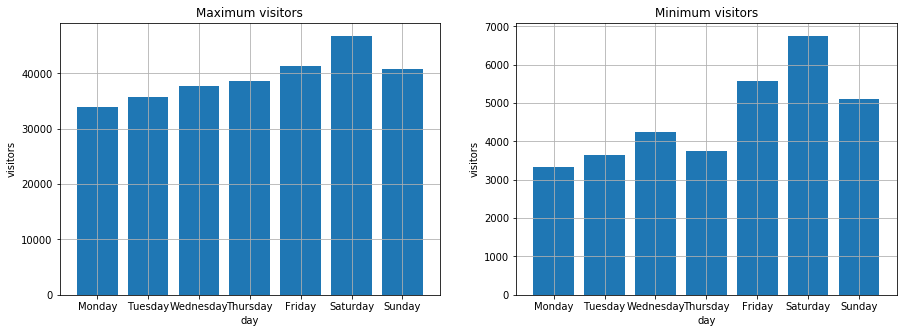

In [90]:
# visualizing the visitors data in terms of bar graph
fig,(axis)=plt.subplots(1, 2,figsize=(15,5))

axis[0].set_title("Maximum visitors")
axis[0].set_xlabel("day")
axis[0].set_ylabel("visitors")
axis[0].grid()
axis[0].bar(visitors['visit_day'],visitors['total_max_visitors']) 

axis[1].set_title("Minimum visitors")
axis[1].set_xlabel("day")
axis[1].set_ylabel("visitors")
axis[1].grid()
axis[1].bar(visitors['visit_day'],visitors['total_min_visitors']) 

### Analysis
##### ~ Saturday has the maximum number of visitors, because first day of the weekend and people make plans on that day and can rest on Sunday
##### ~ Monday has the minimum, since it is the day after weekend
##### ~ Friday and Sunday have similar number of visitors, maybe lot of visitors tend to go to restaurants for dinner or maybe due to office parties which usually happens on Fridays
##### ~ Tuesday and Wednesday has less visitors but not significantly less than Friday and Sunday

### 2.  Let's plot the graph of visitors against all the dates in the "air_visit_data" dataset.

In [91]:
# Reference: https://www.kaggle.com/headsortails/be-my-guest-recruit-restaurant-eda
# counting the number of visitors overally in each date
visitors_by_date=air_visit_data.groupby(["visit_date"],as_index=False)["visitors"].sum()

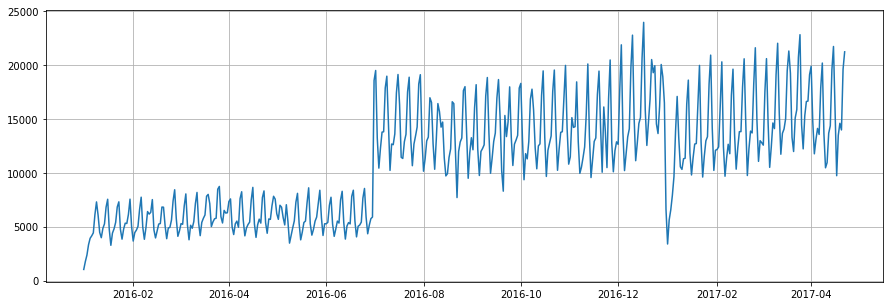

In [100]:
# plotting
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(visitors_by_date['visit_date'],visitors_by_date['visitors']) 

### Analysis
##### ~ There is a sudden spike in number of visitors probably in first week of July month, and no information is provided regarding this.
##### ~ Probably many restaurants must have been registered at a time in the AirREGI site and accordingly the visitors are recorded.
##### ~ There is steep slope in first week of January(most probably New year's day), and again we dint have any information about that
##### ~ People might have wanted to spend and celebrate the day at homes or they might have travelled to other cities/country to celebrate, that might be the reason why less visitors are recorded on New year's day.

### Let's plot the number of restaurants in an area according to AirREGI

In [35]:
# counting the number of restaurants in each area.
res_by_area=air_store_info.groupby(["air_area_name"],as_index=False)["air_store_id"].count().rename(columns={"air_store_id":"total_restaurants"})

In [36]:
# sorting it by number of restaurants
res_by_area=res_by_area.sort_values(by=["total_restaurants"],ascending=False)

In [37]:
# Finding out the average restaurant per area.
mean=res_by_area['total_restaurants'].mean()
print("Average number of restaurants per area:",mean)

Average number of restaurants per area: 8.048543689320388


In [38]:
res_by_area["total_restaurants"].sum()

829

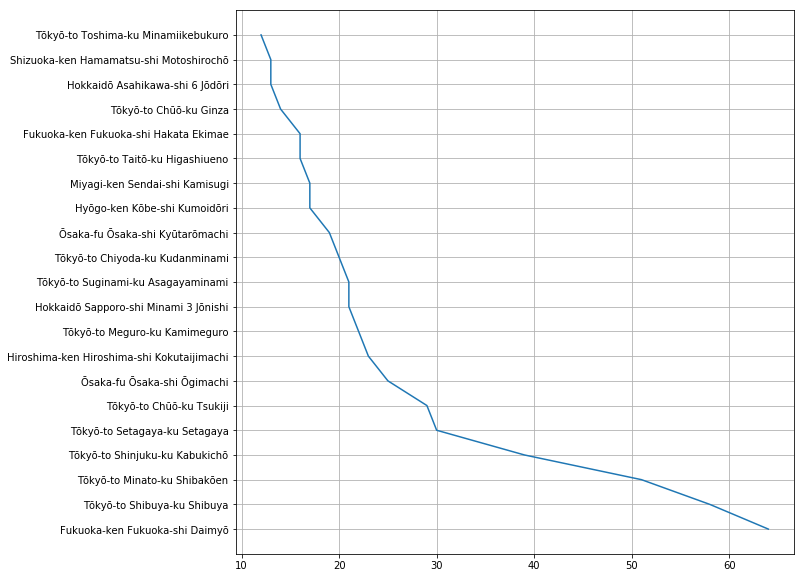

In [42]:
# Difficult to visualize all the areas, so took top 21 areas which has probably more than 100 restaurants.
res_by_area1=res_by_area.head(21)
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(res_by_area1['total_restaurants'],res_by_area1['air_area_name']) 

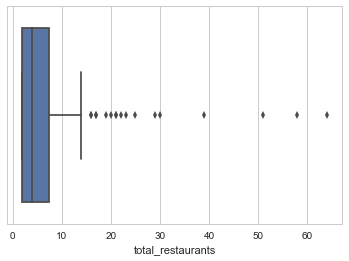

In [24]:
sns.set(style="whitegrid")
ax=sns.boxplot(res_by_area["total_restaurants"])

### Analysis
#### ~ By boxplot we find that 75% of area have number of restaurants between 0 to 8.
#### ~ About 20% of the areas have more than 15 restaurants.
#### ~ Maximum areas are of from Tokyo itself, as it is the capital city of Japan.
#### ~ It's also sensible that more number of restaurants will pull more visitors.

### Let's take look at number of restaurants for genres in AirREGI

In [3]:
# counting the number of restaurants for each genre.
res_by_genre=air_store_info.groupby(['air_genre_name'], as_index=False)['air_store_id'].count().rename(columns={'air_store_id':'number_of_restaurants_per_genre'})

<BarContainer object of 14 artists>

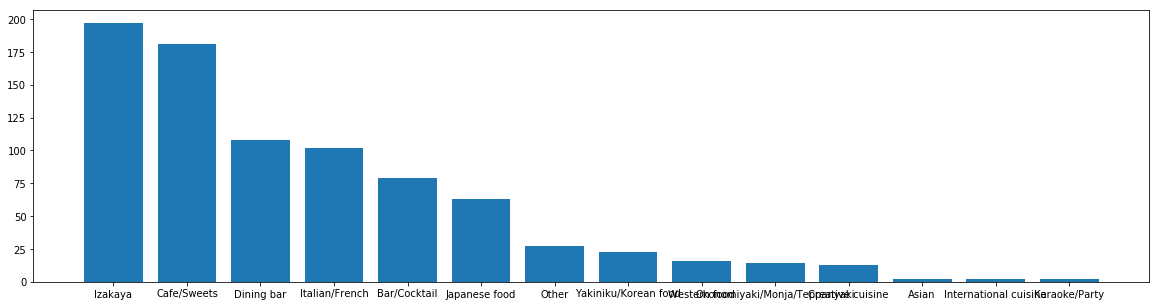

In [12]:
# sorting by the number of restaurants.
res_by_genre=res_by_genre.sort_values(by='number_of_restaurants_per_genre',ascending=False)
plt.figure(figsize=(20,5))
plt.bar(res_by_genre['air_genre_name'],res_by_genre['number_of_restaurants_per_genre'])

### Analysis
#### ~ There are approximately 200 restaurants(highest) with Izakaya genre. Izakaya is a place where alcoholic drinks and snakcs are provided. It's a kind of after-work place. It is similar to pubs in India.
#### ~ There are around 180 cafe/sweets type restaurants, where people go in the morning or evening time.
#### ~ Karaoke party/Internation cuisine/Asian genres are not so popular in Japan.
#### ~ Note: One restaurant might have more than one genre.

### Let's merge the air_reserve and hpg_reserve with store_id_relation dataset and check.

In [103]:
air_stor_id=pd.merge(air_reserve,store_id_relation,how="left",on="air_store_id")

In [104]:
print(air_stor_id["air_store_id"].nunique())
print(air_stor_id["hpg_store_id"].nunique())

314
131


In [51]:
hpg_store_id=pd.merge(hpg_reserve,store_id_relation,how="left",on=["hpg_store_id"])

In [52]:
print(hpg_store_id["air_store_id"].nunique())
print(hpg_store_id["hpg_store_id"].nunique())

150
13325


### Analysis
#### ~ Not all the restaurants are registered in Hot Pepper Gourmet are in AirREGI and viceversa.
#### ~ This is may be due to small size restaurants with low budget.
#### ~ Or people tend to just visit these small size restaurants directly and would not do any reservations.

### Let's plot the number of restaurants in an area according to Hot Pepper Gourmet

In [60]:
# Reference: https://www.kaggle.com/headsortails/be-my-guest-recruit-restaurant-eda
# counting the number of restaurants per genre.
res_by_genre_hpg=hpg_store_info.groupby(['hpg_genre_name'], as_index=False)['hpg_store_id'].count().rename(columns={'hpg_store_id':'number_of_restaurants_per_genre'})

In [61]:
res_by_genre_hpg=res_by_genre_hpg.sort_values(by="number_of_restaurants_per_genre",ascending=False)
res_by_genre_hpg.head()

hpg_genre_name  number_of_restaurants_per_genre
15         Japanese style                             1750
11  International cuisine                              700
6                Creation                              410
21                Seafood                              339
10           Grilled meat                              325

<BarContainer object of 10 artists>

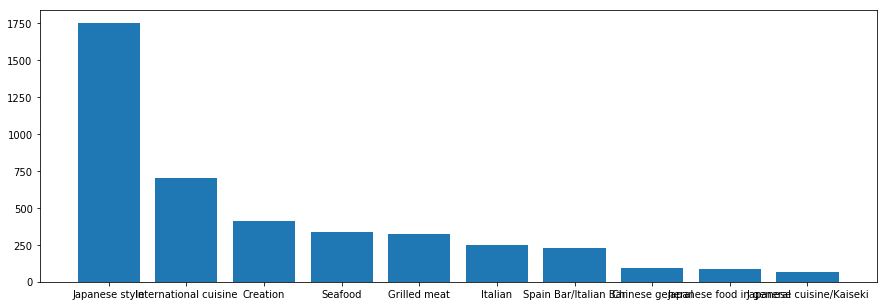

In [63]:
res_by_genre_hpg=res_by_genre_hpg.head(10)
plt.figure(figsize=(15,5))
plt.bar(res_by_genre_hpg['hpg_genre_name'],res_by_genre_hpg['number_of_restaurants_per_genre'])

### Analysis
#### ~ Again, not all genres are present in AirREGI site, HPG site has many more genres that AirREGI
#### ~ Japanese styled restaurants are significantly more than any other genres for obvious reasons.
#### ~ Followed by International cuisine, Creation, Seafood, Grilled meat, etc.
#### ~ Udon/Soba(type of a noodle) and some specific international cuisines type restaurants are not many in numbers.
#### ~ Note: One restaurant might have more than one genre.


### Let's see the number of restaurants in each areas in HPG.

In [68]:
# counting the number of restaurants by grouping the areas.
res_by_area_hpg=hpg_store_info.groupby(['hpg_area_name'], as_index=False)['hpg_store_id'].count().rename(columns={'hpg_store_id':'number_of_restaurants_per_area'})

In [77]:
# sorting in dscending order according to number of restaurants.
res_by_area_hpg=res_by_area_hpg.sort_values(by='number_of_restaurants_per_area',ascending=False)
res_by_area_hpg.head(20)

hpg_area_name  number_of_restaurants_per_area
94                Tōkyō-to Shinjuku-ku None                             257
66                   Tōkyō-to Chūō-ku Ginza                             198
30                  Hyōgo-ken Kōbe-shi None                             163
117     Ōsaka-fu Ōsaka-shi Shinsaibashisuji                             150
52              Osaka Prefecture Osaka None                             145
13      Hiroshima-ken Hiroshima-shi Hondōri                             135
90                 Tōkyō-to Shibuya-ku None                             127
83              Tōkyō-to Minato-ku Takanawa                             122
101                Tōkyō-to Toshima-ku None                             119
51                           None None None                             117
69      Tōkyō-to Hachiōji-shi Ishikawamachi                             114
21    Hokkaidō Sapporo-shi Minami 4 Jōnishi                             110
98                   Tōkyō-to Taitō-ku None                             100
5              Fukuoka-ken Fukuoka-shi None                              90
55   Shizuoka-ken Hamamatsu-shi Sukenobuchō                              90
64                 Tōkyō-to Chiyoda-ku None                              89
67                    Tōkyō-to Chūō-ku None                              86
97             Tōkyō-to Sumida-ku Tachibana                              86
22                Hokkaidō Sapporo-shi None                              84
60      Shizuoka-ken Shizuoka-shi Hinodechō                              79

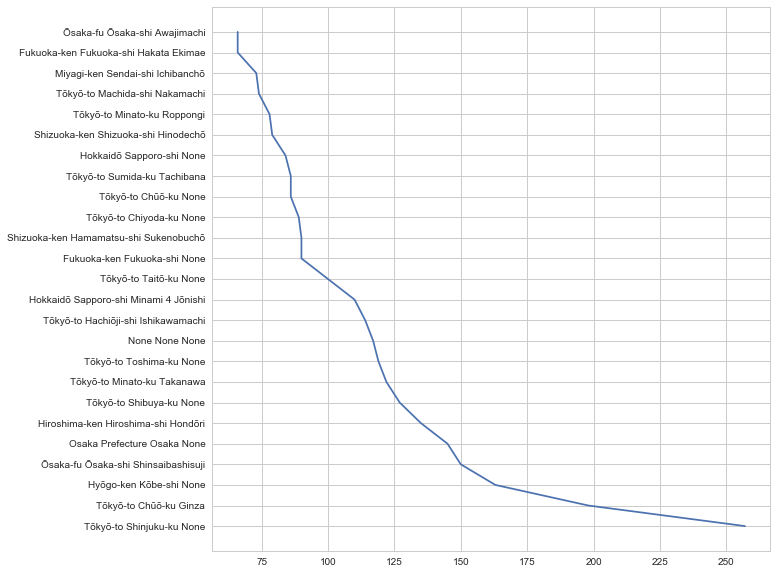

In [78]:
# plotting
res_by_area_hpg=res_by_area_hpg.head(25)
plt.figure(figsize=(10,10))
plt.plot(res_by_area_hpg['number_of_restaurants_per_area'],res_by_area_hpg['hpg_area_name']) 

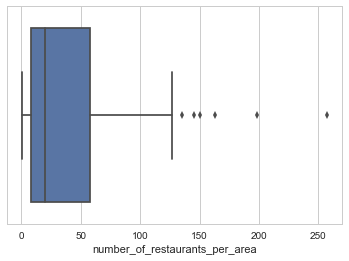

In [74]:
# boxplot
sns.set(style="whitegrid")
ax=sns.boxplot(res_by_area_hpg['number_of_restaurants_per_area'])

### Analysis
#### ~ 75% of areas have around 55-60 restaurants
#### ~ Around 11% areas according to HPG have more than 100 restaurants.
#### ~ We do not have any information about the size of the area, a larger size area can have a large number of restaurants.
#### ~ Tokyo, Osaka like major cities have large number of restaurants.
#### ~ There is a area name "None None None", which has 117 restaurants but is unknown for which area or city it refers to.

### Let's look into holidays dataset.

In [68]:
holiday_count=date_info.groupby(['holiday_flg']).count()
print(holiday_count.drop(['calendar_date'],axis=1))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ")
print((35/len(date_info))*100,"% of dates are holidays")

             day_of_week
holiday_flg             
0                    482
1                     35
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
6.769825918762089 % of dates are holidays


### Let's check the difference between reservation time and visit time of the restaurants in Hot Pepper Gourmet and AirREGI sites.

In [75]:
hpg_store_id.isnull().sum()

hpg_store_id              0
visit_datetime            0
reserve_datetime          0
reserve_visitors          0
air_store_id        1972137
dtype: int64

In [56]:
hpg_store_id["visit_datetime"]=pd.to_datetime(hpg_store_id["visit_datetime"])
hpg_store_id["reserve_datetime"]=pd.to_datetime(hpg_store_id["reserve_datetime"])
time_difference_in_hpg=hpg_store_id["visit_datetime"]-hpg_store_id["reserve_datetime"]

In [57]:
print("Maximum time between reservation and visit",time_difference_in_hpg.max())
print("Average reservation time",time_difference_in_hpg.mean())
print("median of difference",time_difference_in_hpg.median())

Maximum time between reservation and visit 368 days 03:00:00
Average reservation time 7 days 10:57:20.775875
median of difference 4 days 07:00:00


In [105]:
air_stor_id.isnull().sum()

air_store_id            0
visit_datetime          0
reserve_datetime        0
reserve_visitors        0
hpg_store_id        56114
dtype: int64

In [106]:
air_stor_id["visit_datetime"]=pd.to_datetime(air_stor_id["visit_datetime"])
air_stor_id["reserve_datetime"]=pd.to_datetime(air_stor_id["reserve_datetime"])
time_difference_in_air=air_stor_id["visit_datetime"]-air_stor_id["reserve_datetime"]

In [107]:
print("Maximum time between reservation and visit",time_difference_in_air.max())
print("Average reservation time",time_difference_in_air.mean())
print("median of difference",time_difference_in_air.median())

Maximum time between reservation and visit 393 days 03:00:00
Average reservation time 8 days 07:05:51.044621
median of difference 2 days 02:00:00


### Plotting the restaurants in a map using libraries

In [54]:
# using density_mapbox
# https://plotly.com/python/mapbox-density-heatmaps/
# for Hot Pepper Gourmet restaurants
import plotly.express as px
import pandas as pd
fig = px.density_mapbox(hpg_store_info, lat=hpg_store_info['latitude'], lon=hpg_store_info['longitude'], radius=5,
                        center=dict(lat=36.2048, lon=138.2529), zoom=2,
                        mapbox_style="stamen-terrain")
fig.show()

In [55]:
# https://plotly.com/python/mapbox-density-heatmaps/
# for AirREGI restaurants.

fig = px.density_mapbox(air_store_info, lat=air_store_info['latitude'], lon=air_store_info['longitude'], radius=5,
                        center=dict(lat=36.2048, lon=138.2529), zoom=2,
                        mapbox_style="stamen-terrain")
fig.show()

In [3]:
# using folium
# https://colab.research.google.com/drive/1TexiXFhROP0mjbAyk8Rhj-IByqKp7tyv#scrollTo=HWLsXmMfpYSD (New york Taxi case study)
# for AirREGI restaurants
import folium
mapping = folium.Map(location=[36.2048, 138.2529],tiles='Stamen Toner')

for i,j in air_store_info.iterrows():
    if int(j['latitude'])!= 0:
        folium.Marker(list((j['latitude'],j['longitude']))).add_to(mapping)
mapping

~Folium does not work well for large number of points probably if there are more than 1000 points to plot.
~Similarly we can plot of "hpg_store_info" but since it has 4690 poins to plot and the notebook probably will be slow so I did not plot, but it will be same as "air_store_info" as above.

In [ ]:
# using folium
# https://colab.research.google.com/drive/1TexiXFhROP0mjbAyk8Rhj-IByqKp7tyv#scrollTo=HWLsXmMfpYSD (New york Taxi case study)



#import folium
#mapping = folium.Map(location=[36.2048, 138.2529],tiles='Stamen Toner')

#for i,j in hpg_store_info.iterrows():
#    if int(j['latitude'])!= 0:
#        folium.Marker(list((j['latitude'],j['longitude']))).add_to(mapping)
#mapping

### Feature-1 : Nearest neighbours for each restaurants

1. For any given location we can find out the nearby restaurants in a given radius.
2. Here, we have latitudes and longitudes for all the restaurants.
3. If we connsider each set of latitude and longitude to be one location, then with a given radius we can find what are all the set of latitudes and longitudes fall under that radius. 

In [46]:
# code taken from,

# https://stackoverflow.com/questions/238260/how-to-calculate-the-bounding-box-for-a-given-lat-lng-location/238558#238558
# by Federico A. Ramponi (https://stackoverflow.com/users/18770/federico-a-ramponi)

# This snippet of code basically takes a set of latitude and longitude coverts it into radius(distance) due to \
# speroidical shape of earth \
# and returns 4 coordinates which surround the set of latitude and longitude as a box.


import math
# degrees to radians
def deg2rad(degrees):
    return math.pi*degrees/180.0
# radians to degrees
def rad2deg(radians):
    return 180.0*radians/math.pi

# Semi-axes of WGS-84 geoidal reference
WGS84_a = 6378137.0  # Major semiaxis [m]
WGS84_b = 6356752.3  # Minor semiaxis [m]

# Earth radius at a given latitude, according to the WGS-84 ellipsoid [m]
def WGS84EarthRadius(lat):
    # http://en.wikipedia.org/wiki/Earth_radius
    An = WGS84_a*WGS84_a * math.cos(lat)
    Bn = WGS84_b*WGS84_b * math.sin(lat)
    Ad = WGS84_a * math.cos(lat)
    Bd = WGS84_b * math.sin(lat)
    return math.sqrt( (An*An + Bn*Bn)/(Ad*Ad + Bd*Bd) )

# Bounding box surrounding the point at given coordinates,
# assuming local approximation of Earth surface as a sphere
# of radius given by WGS84
def boundingBox(latitudeInDegrees, longitudeInDegrees, halfSideInKm):
    lat = deg2rad(latitudeInDegrees)
    lon = deg2rad(longitudeInDegrees)
    halfSide = 1000*halfSideInKm

    # Radius of Earth at given latitude
    radius = WGS84EarthRadius(lat)
    # Radius of the parallel at given latitude
    pradius = radius*math.cos(lat)

    latMin = lat - halfSide/radius
    latMax = lat + halfSide/radius
    lonMin = lon - halfSide/pradius
    lonMax = lon + halfSide/pradius

    return (rad2deg(latMin), rad2deg(lonMin), rad2deg(latMax), rad2deg(lonMax))

In [7]:
bounding_box_lat=[]
bounding_box_lon=[]
for i in range(len(air_store_info)):
    bounding_box_lat.append(air_store_info['latitude'][i])
    bounding_box_lon.append(air_store_info['longitude'][i])
len(bounding_box_lat)     

829

In [8]:
neighbour=[]
lat_1=[]
lon_1=[]
lat_2=[]
lon_2=[]
for i in range(len(air_store_info)):    
    lat1, lon1, lat2, lon2=boundingBox(bounding_box_lat[i],bounding_box_lon[i],1.5)
    lat_1.append(lat1)
    lon_1.append(lon1)
    lat_2.append(lat2)
    lon_2.append(lon2)

In [9]:
neighbour=[]
for i in range(len(air_store_info)):
    count=0
    for j in range(len(air_store_info)):        
        if bounding_box_lat[j]>lat_1[i] and bounding_box_lat[j]<lat_2[i] and bounding_box_lon[j]>lon_1[i] and bounding_box_lon[j]<lon_2[i]:
            count=count+1
    neighbour.append(count-1)        

In [10]:
air_store_info['nearest_neighbour']=neighbour

### Merging the dataframes. 

In [84]:
air_store_info=air_store_info.rename(columns={"air_genre_name":"genre_name","air_area_name":"area_name"})
hpg_store_info=hpg_store_info.rename(columns={"hpg_genre_name":"genre_name","hpg_area_name":"area_name"})
hpg_store_info.head()

hpg_store_id      genre_name                      area_name  \
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
1  hpg_e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
2  hpg_2976f7acb4b3a3bc  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
3  hpg_e51a522e098f024c  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
4  hpg_e3d0e1519894f275  Japanese style  Tōkyō-to Setagaya-ku Taishidō   

    latitude   longitude  
0  35.643675  139.668221  
1  35.643675  139.668221  
2  35.643675  139.668221  
3  35.643675  139.668221  
4  35.643675  139.668221

In [68]:
date_info=date_info.rename(columns={"calendar_date":"visit_date"})

In [13]:
total_data=pd.merge(air_visit_data,date_info,how='left',on=['visit_date'])
total_data=pd.merge(total_data,store_id_relation,how='left',on= ['air_store_id'])
total_data=pd.merge(total_data,air_store_info,how='left',on= ['air_store_id'])
total_data=pd.merge(total_data,hpg_store_info,how='left',on= ['hpg_store_id','latitude','longitude','genre_name','area_name'])

In [14]:
total_data['air_store_id'].nunique() # 829

829

In [16]:
total_data['nearest_neighbour'].isnull().sum()

0

In [17]:
total_data=total_data.drop(columns=['hpg_store_id'])

In [18]:
total_data.head()

air_store_id  visit_date  visitors day_of_week  holiday_flg  \
0  air_ba937bf13d40fb24  2016-01-13        25   Wednesday            0   
1  air_ba937bf13d40fb24  2016-01-14        32    Thursday            0   
2  air_ba937bf13d40fb24  2016-01-15        29      Friday            0   
3  air_ba937bf13d40fb24  2016-01-16        22    Saturday            0   
4  air_ba937bf13d40fb24  2016-01-18         6      Monday            0   

   genre_name                     area_name   latitude   longitude  \
0  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
1  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
2  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
3  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
4  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   

   nearest_neighbour  
0                 50  
1                 50  
2                 50  
3                 50  
4                 50

In [24]:
# coverting the dataframe to a csv file.
total_data.to_csv("total_data.csv",index=False)
total_data=pd.read_csv("total_data.csv")

NameError: name 'total_data' is not defined

In [58]:
# Reading the csv file.
total_data=pd.read_csv("total_data.csv")

In [59]:
total_data.shape


(252108, 10)

### Treating null values

In [60]:
total_data.isnull().sum()

air_store_id         0
visit_date           0
visitors             0
day_of_week          0
holiday_flg          0
genre_name           0
area_name            0
latitude             0
longitude            0
nearest_neighbour    0
dtype: int64

~ there are no null values 

Converting "day_of_week" to numerical data

In [61]:
total_data['day_of_week']=total_data['day_of_week'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

In [62]:
total_data.head()

air_store_id  visit_date  visitors  day_of_week  holiday_flg  \
0  air_ba937bf13d40fb24  2016-01-13        25            3            0   
1  air_ba937bf13d40fb24  2016-01-14        32            4            0   
2  air_ba937bf13d40fb24  2016-01-15        29            5            0   
3  air_ba937bf13d40fb24  2016-01-16        22            6            0   
4  air_ba937bf13d40fb24  2016-01-18         6            1            0   

   genre_name                     area_name   latitude   longitude  \
0  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
1  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
2  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
3  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
4  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   

   nearest_neighbour  
0                 50  
1                 50  
2                 50  
3                 50  
4                 50

### Feature 2 : latitude and longitude

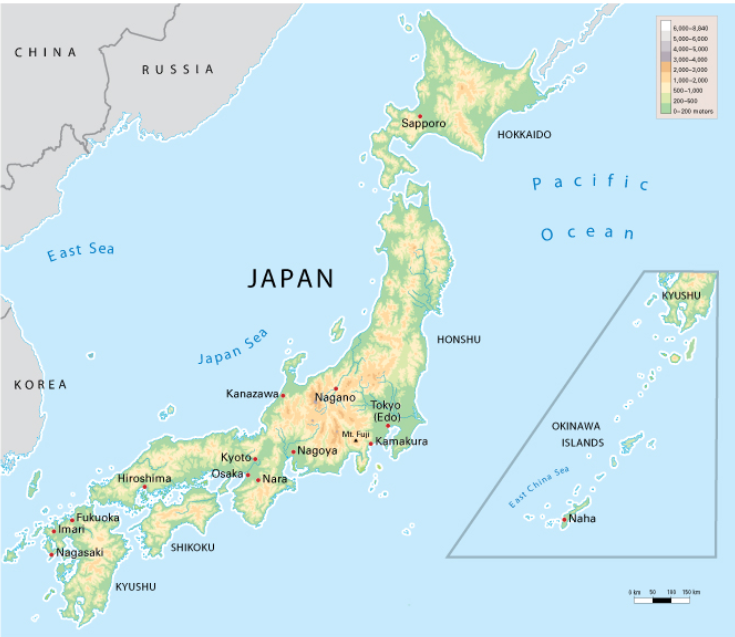
 1. If we take a look at Japan's geography we can see that all the major cities lie between Tokyo to Nagasaki in south.
 2. If we draw a line then we will get a slanting line.
 3. It can be significantly differentiated by longitude but not that easily with latitudes.
 4. So, I gave more weightage to longitude and less weightage to latitude and made a summation.


In [63]:
# feature 2
total_data['latlong']=(0.5*total_data['latitude'])+(2*total_data['longitude'])

In [64]:
total_data.head()

air_store_id  visit_date  visitors  day_of_week  holiday_flg  \
0  air_ba937bf13d40fb24  2016-01-13        25            3            0   
1  air_ba937bf13d40fb24  2016-01-14        32            4            0   
2  air_ba937bf13d40fb24  2016-01-15        29            5            0   
3  air_ba937bf13d40fb24  2016-01-16        22            6            0   
4  air_ba937bf13d40fb24  2016-01-18         6            1            0   

   genre_name                     area_name   latitude   longitude  \
0  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
1  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
2  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
3  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
4  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   

   nearest_neighbour     latlong  
0                 50  297.332232  
1                 50  297.332232  
2                 50  297.332232  
3                 50  297.332232  
4                 50  297.332232

### Key Takeaways from EDA and Feature Engineering

#### Exploratory Data Analysis

1. Saturday attracts the most number of visitors followed by Friday and Sunday

2. Sudden spike in number of visitors probably in first week of July month, and no information is provided regarding this may be beacuse many restaurants must have been registered at a time in the AirREGI site and accordingly the visitors are recorded.

3. Average restaurants per area is 8.04

4. About 20% of the areas have more than 15 restaurants

5. Maximum areas are of from Tokyo itself, as it is the capital city of Japan.

6. There are approximately 200 restaurants(highest) with Izakaya genre (Izakaya - a type of bar-restaurant)

7. Karaoke party/Internation cuisine/Asian genres are not so popular in Japan.

8. Not all the restaurants are registered in Hot Pepper Gourmet are in AirREGI and viceversa.

9. About 6.7 % of dates are holidays

#### Feature Engineering

1. Nearest Neighbours:

- We find the nearest neighbours for a particular restaurant using the latitudes and longitudes.

- More number of nearest neighbours can tell probably that the restaurant is located in a popular place and it might attract more number of visitors and hecne impacting the target variable.

2. latlong 

- Create a separate feature using latitude and longitude

- operation : 2*longitude + 0.5*latitude (more weightage to logitudes because of Japan's geography, we can differentiate the locations of restaurants)

- Creating a univariate feature so that a decsion tree like model can can easily decode under which latlong it falls and hence impacting the target variable. 

### Dummy Model / Baseline Solution
~ The predicted visitors are the number of average visitors on that particular day of the week.

In [14]:
# calculating average visitors fro each day of the week
avg_visitors_count_by_day=total_data.groupby(["day_of_week"],as_index=False)["visitors"].mean()

In [46]:
avg_visitors_count_by_day

day_of_week   visitors
0            1  17.177009
1            2  17.672137
2            3  19.230121
3            4  18.922702
4            5  23.072737
5            6  26.313688
6            7  23.873362

In [42]:
# extracting the id and date from "id" column
sample_submission['air_store_id'] = sample_submission['id'].map(lambda x:str(x)[:20])
sample_submission['visit_datetime']=sample_submission['id'].map(lambda x:str(x)[21:])
sample_submission['visit_datetime'] = pd.to_datetime(sample_submission['visit_datetime'])

In [43]:
sample_submission.head()

id  visitors          air_store_id  \
0  air_00a91d42b08b08d9_2017-04-23         0  air_00a91d42b08b08d9   
1  air_00a91d42b08b08d9_2017-04-24         0  air_00a91d42b08b08d9   
2  air_00a91d42b08b08d9_2017-04-25         0  air_00a91d42b08b08d9   
3  air_00a91d42b08b08d9_2017-04-26         0  air_00a91d42b08b08d9   
4  air_00a91d42b08b08d9_2017-04-27         0  air_00a91d42b08b08d9   

  visit_datetime  
0     2017-04-23  
1     2017-04-24  
2     2017-04-25  
3     2017-04-26  
4     2017-04-27

In [47]:
sample_submission['visit_datetime']=pd.to_datetime(sample_submission['visit_datetime'])
sample_submission["day_of_week"]=sample_submission["visit_datetime"].dt.dayofweek

In [55]:
sample_submission["day_of_week"]=sample_submission["day_of_week"].replace([0,1,2,3,4,5,6],[1,2,3,4,5,6,7])

In [56]:
# merging with avg_visitors_count_by_day where we extracted the averages visitors of a day in a week

predicted_visitors=pd.merge(sample_submission,avg_visitors_count_by_day,how='left',on=['day_of_week'])

In [70]:
predicted_visitors=predicted_visitors.drop(columns=["visitors_x","air_store_id","visit_datetime","day_of_week"],axis=1)

In [71]:
predicted_visitors=predicted_visitors.rename(columns={"visitors_y": "visitors"})

In [73]:
predicted_visitors.to_csv("predicted_visitors.csv",index=False)
predicted_visitors=pd.read_csv("predicted_visitors.csv")

I have submitted the .csv file to get the scores for the baseline solution in kaggle

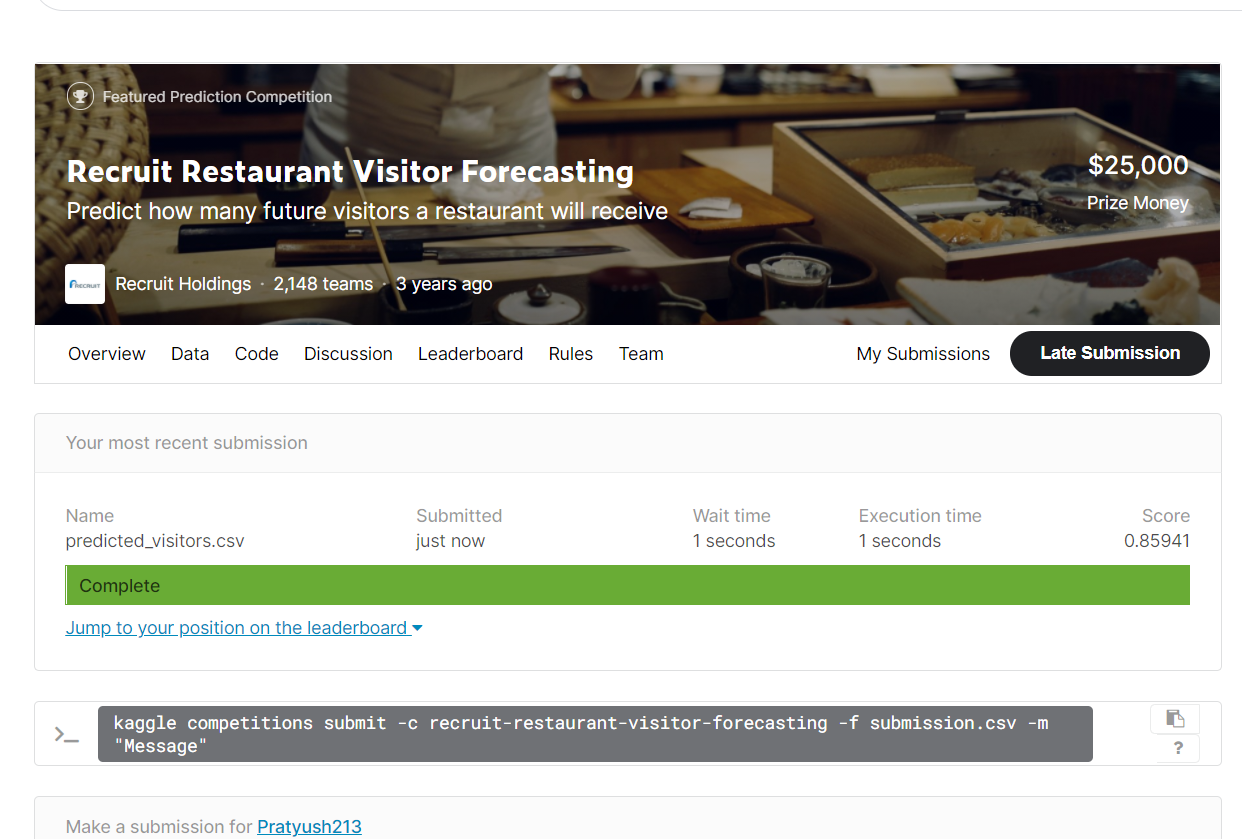

and the score which I got is 85.941

https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/submit - Link

### Feature Selection

In [65]:
# encoding the air_store_id, area_name, genre_name
le = LabelEncoder()

label1=le.fit(total_data['air_store_id'].unique())
label2=le.fit(total_data['area_name'].unique())
label3=le.fit(total_data['genre_name'].unique())

total_data['label_encoded_id']=label1.fit_transform(total_data['air_store_id'])
total_data['label_encoded_area']=label2.fit_transform(total_data['area_name'])
total_data['label_encoded_genre']=label3.fit_transform(total_data['genre_name'])

In [66]:
total_data['visit_date']=pd.to_datetime(total_data['visit_date'])
total_data['visit_year']=total_data['visit_date'].dt.year
total_data['visit_month']=total_data['visit_date'].dt.month
total_data['visit_date']=total_data['visit_date'].dt.date

In [67]:
total_data.head()

air_store_id  visit_date  visitors  day_of_week  holiday_flg  \
0  air_ba937bf13d40fb24  2016-01-13        25            3            0   
1  air_ba937bf13d40fb24  2016-01-14        32            4            0   
2  air_ba937bf13d40fb24  2016-01-15        29            5            0   
3  air_ba937bf13d40fb24  2016-01-16        22            6            0   
4  air_ba937bf13d40fb24  2016-01-18         6            1            0   

   genre_name                     area_name   latitude   longitude  \
0  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
1  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
2  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
3  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
4  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   

   nearest_neighbour     latlong  label_encoded_id  label_encoded_area  \
0                 50  297.332232               603                  62   
1                 50  297.332232               603                  62   
2                 50  297.332232               603                  62   
3                 50  297.332232               603                  62   
4                 50  297.332232               603                  62   

   label_encoded_genre  visit_year  visit_month  
0                    4        2016            1  
1                    4        2016            1  
2                    4        2016            1  
3                    4        2016            1  
4                    4        2016            1

In [53]:
# https://machinelearningmastery.com/feature-selection-machine-learning-python/

from sklearn.ensemble import ExtraTreesClassifier
Y = total_data["visitors"]
X = total_data.drop(columns=["visitors","air_store_id","genre_name","area_name","visit_date"],axis=1)

# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X,Y)
print(model.feature_importances_)

[0.12703759 0.03249424 0.00979776 0.00960963 0.00899046 0.00974083
 0.20960754 0.00998803 0.04090177 0.51083519 0.03099695]


#### ~ "visit_month" column is showing comparatively more importance


In [54]:
X.head()

day_of_week  holiday_flg   latitude   longitude  nearest_neighbour  \
0            3            0  35.658068  139.751599                 50   
1            4            0  35.658068  139.751599                 50   
2            5            0  35.658068  139.751599                 50   
3            6            0  35.658068  139.751599                 50   
4            1            0  35.658068  139.751599                 50   

      latlong  label_encoded_id  label_encoded_area  label_encoded_genre  \
0  297.332232               603                  62                    4   
1  297.332232               603                  62                    4   
2  297.332232               603                  62                    4   
3  297.332232               603                  62                    4   
4  297.332232               603                  62                    4   

   visit_month  visit_year  
0            1        2016  
1            1        2016  
2            1        2016  
3            1        2016  
4            1        2016

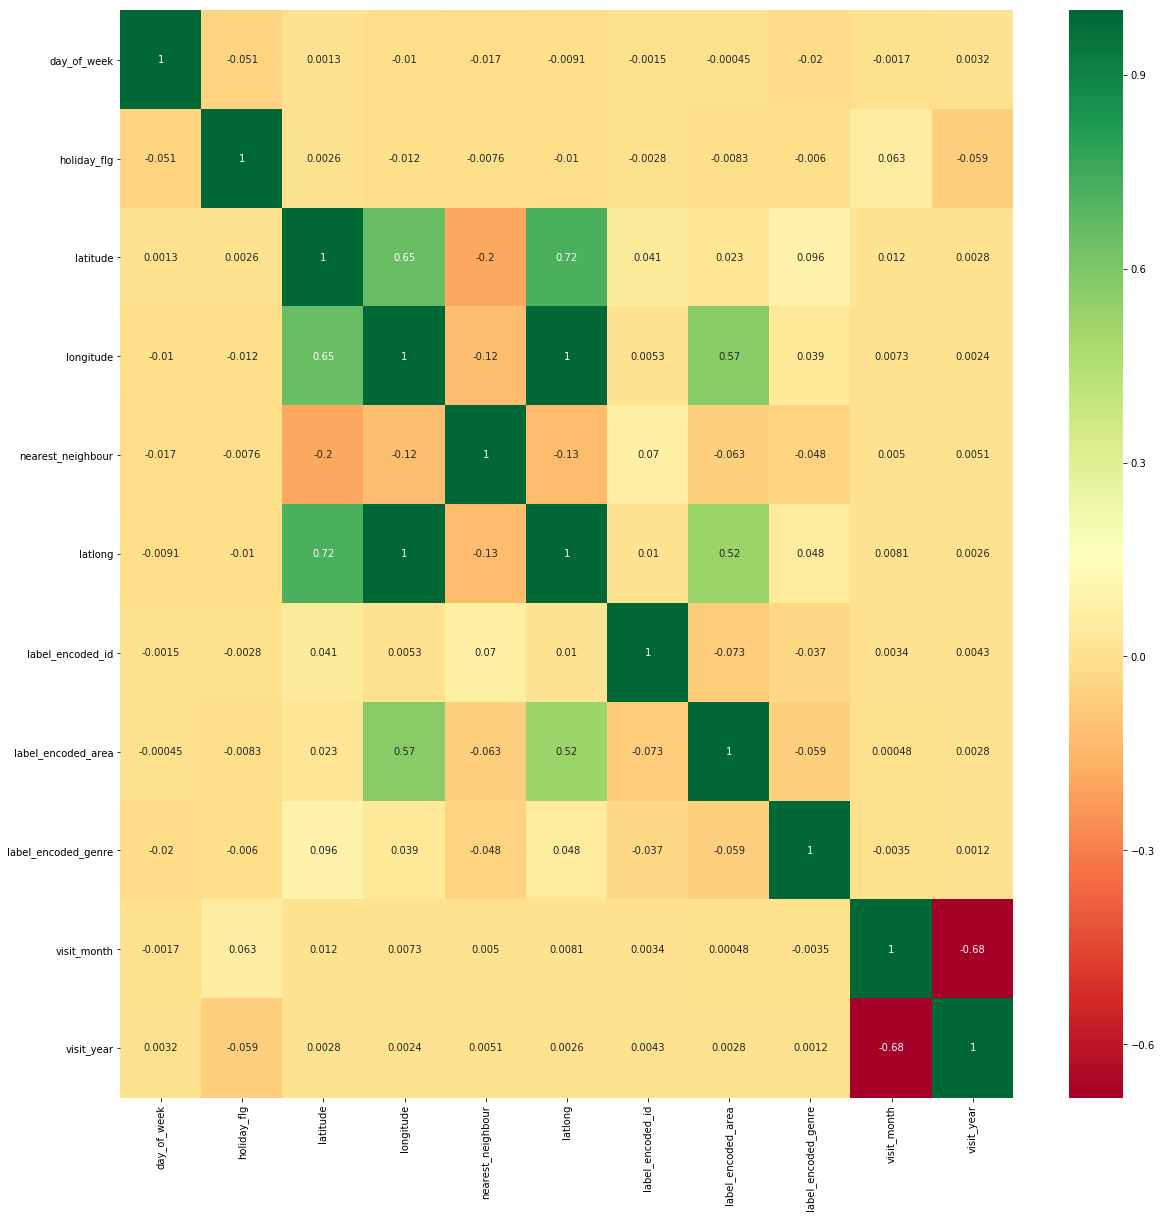

In [55]:
# Let's plot a heat map of X

# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
plt.figure(figsize=(20,20))
g=sns.heatmap(X.corr(),annot=True,cmap="RdYlGn")

#### ~ None of the features are impacting any other feature except latitude and longitude features.
#### ~ visit_month and visit_year are negatively impacting each other.

In [41]:
total_data.head()

air_store_id  visit_date  visitors  day_of_week  holiday_flg  \
0  air_ba937bf13d40fb24  2016-01-13        25            3            0   
1  air_ba937bf13d40fb24  2016-01-14        32            4            0   
2  air_ba937bf13d40fb24  2016-01-15        29            5            0   
3  air_ba937bf13d40fb24  2016-01-16        22            6            0   
4  air_ba937bf13d40fb24  2016-01-18         6            1            0   

   genre_name                     area_name   latitude   longitude  \
0  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
1  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
2  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
3  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   
4  Dining bar  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599   

   nearest_neighbour     latlong  label_encoded_id  label_encoded_area  \
0                 50  297.332232               603                  62   
1                 50  297.332232               603                  62   
2                 50  297.332232               603                  62   
3                 50  297.332232               603                  62   
4                 50  297.332232               603                  62   

   label_encoded_genre  visit_year  visit_month  
0                    4        2016            1  
1                    4        2016            1  
2                    4        2016            1  
3                    4        2016            1  
4                    4        2016            1

### Preparing Test data

In [94]:
air_store_info=air_store_info.rename(columns={"air_genre_name":"genre_name","air_area_name":"area_name"})
hpg_store_info=hpg_store_info.rename(columns={"hpg_genre_name":"genre_name","hpg_area_name":"area_name"})
hpg_store_info.head()

hpg_store_id      genre_name                      area_name  \
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
1  hpg_e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
2  hpg_2976f7acb4b3a3bc  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
3  hpg_e51a522e098f024c  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
4  hpg_e3d0e1519894f275  Japanese style  Tōkyō-to Setagaya-ku Taishidō   

    latitude   longitude  
0  35.643675  139.668221  
1  35.643675  139.668221  
2  35.643675  139.668221  
3  35.643675  139.668221  
4  35.643675  139.668221

In [95]:
# extracting the id and date from "id" column
sample_submission['air_store_id'] = sample_submission['id'].map(lambda x:str(x)[:20])
sample_submission['visit_date']=sample_submission['id'].map(lambda x:str(x)[21:])
sample_submission['visit_date'] = pd.to_datetime(sample_submission['visit_date'])


In [96]:
#sample_submission['visit_date']=sample_submission['visit_date'].dt.date
sample_submission.head()

id  visitors          air_store_id visit_date
0  air_00a91d42b08b08d9_2017-04-23         0  air_00a91d42b08b08d9 2017-04-23
1  air_00a91d42b08b08d9_2017-04-24         0  air_00a91d42b08b08d9 2017-04-24
2  air_00a91d42b08b08d9_2017-04-25         0  air_00a91d42b08b08d9 2017-04-25
3  air_00a91d42b08b08d9_2017-04-26         0  air_00a91d42b08b08d9 2017-04-26
4  air_00a91d42b08b08d9_2017-04-27         0  air_00a91d42b08b08d9 2017-04-27

In [97]:
sample_submission['visit_dow'] = sample_submission['visit_date'].dt.dayofweek
sample_submission['visit_year']=sample_submission['visit_date'].dt.year
sample_submission['visit_month'] = sample_submission['visit_date'].dt.month
#sample_submission['visit_date']=sample_submission['visit_date'].dt.date

In [91]:
test_data=sample_submission.copy(deep=True)

In [98]:
sample_submission.head()

id  visitors          air_store_id visit_date  \
0  air_00a91d42b08b08d9_2017-04-23         0  air_00a91d42b08b08d9 2017-04-23   
1  air_00a91d42b08b08d9_2017-04-24         0  air_00a91d42b08b08d9 2017-04-24   
2  air_00a91d42b08b08d9_2017-04-25         0  air_00a91d42b08b08d9 2017-04-25   
3  air_00a91d42b08b08d9_2017-04-26         0  air_00a91d42b08b08d9 2017-04-26   
4  air_00a91d42b08b08d9_2017-04-27         0  air_00a91d42b08b08d9 2017-04-27   

   visit_dow  visit_year  visit_month  
0          6        2017            4  
1          0        2017            4  
2          1        2017            4  
3          2        2017            4  
4          3        2017            4

In [99]:
date_info=date_info.rename(columns={"calendar_date":"visit_date"})
date_info['visit_date'] = pd.to_datetime(date_info['visit_date'])

In [100]:
test_data=pd.merge(sample_submission,date_info,how='left',on=['visit_date'])
test_data=pd.merge(test_data,store_id_relation,how='left',on= ['air_store_id'])
test_data=pd.merge(test_data,air_store_info,how='left',on= ['air_store_id'])
test_data=pd.merge(test_data,hpg_store_info,how='left',on= ['hpg_store_id','latitude','longitude','genre_name','area_name'])

In [101]:
test_data.head()

id  visitors          air_store_id visit_date  \
0  air_00a91d42b08b08d9_2017-04-23         0  air_00a91d42b08b08d9 2017-04-23   
1  air_00a91d42b08b08d9_2017-04-24         0  air_00a91d42b08b08d9 2017-04-24   
2  air_00a91d42b08b08d9_2017-04-25         0  air_00a91d42b08b08d9 2017-04-25   
3  air_00a91d42b08b08d9_2017-04-26         0  air_00a91d42b08b08d9 2017-04-26   
4  air_00a91d42b08b08d9_2017-04-27         0  air_00a91d42b08b08d9 2017-04-27   

   visit_dow  visit_year  visit_month day_of_week  holiday_flg  \
0          6        2017            4      Sunday            0   
1          0        2017            4      Monday            0   
2          1        2017            4     Tuesday            0   
3          2        2017            4   Wednesday            0   
4          3        2017            4    Thursday            0   

           hpg_store_id      genre_name                        area_name  \
0  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
1  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
2  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
3  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
4  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   

    latitude   longitude  
0  35.694003  139.753595  
1  35.694003  139.753595  
2  35.694003  139.753595  
3  35.694003  139.753595  
4  35.694003  139.753595

In [102]:
test_data=test_data.drop(columns=['visitors'])

In [103]:
test_data.head()

id          air_store_id visit_date  \
0  air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9 2017-04-23   
1  air_00a91d42b08b08d9_2017-04-24  air_00a91d42b08b08d9 2017-04-24   
2  air_00a91d42b08b08d9_2017-04-25  air_00a91d42b08b08d9 2017-04-25   
3  air_00a91d42b08b08d9_2017-04-26  air_00a91d42b08b08d9 2017-04-26   
4  air_00a91d42b08b08d9_2017-04-27  air_00a91d42b08b08d9 2017-04-27   

   visit_dow  visit_year  visit_month day_of_week  holiday_flg  \
0          6        2017            4      Sunday            0   
1          0        2017            4      Monday            0   
2          1        2017            4     Tuesday            0   
3          2        2017            4   Wednesday            0   
4          3        2017            4    Thursday            0   

           hpg_store_id      genre_name                        area_name  \
0  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
1  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
2  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
3  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
4  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   

    latitude   longitude  
0  35.694003  139.753595  
1  35.694003  139.753595  
2  35.694003  139.753595  
3  35.694003  139.753595  
4  35.694003  139.753595

In [104]:
test_data['day_of_week']=test_data['day_of_week'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

In [105]:
test_data['latlong']=(0.5*test_data['latitude'])+(2*test_data['longitude'])

In [106]:
test_data['label_encoded_id']=label1.fit_transform(test_data['air_store_id'])
test_data['label_encoded_area']=label2.fit_transform(test_data['area_name'])
test_data['label_encoded_genre']=label3.fit_transform(test_data['genre_name'])

In [107]:
test_data.head()

id          air_store_id visit_date  \
0  air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9 2017-04-23   
1  air_00a91d42b08b08d9_2017-04-24  air_00a91d42b08b08d9 2017-04-24   
2  air_00a91d42b08b08d9_2017-04-25  air_00a91d42b08b08d9 2017-04-25   
3  air_00a91d42b08b08d9_2017-04-26  air_00a91d42b08b08d9 2017-04-26   
4  air_00a91d42b08b08d9_2017-04-27  air_00a91d42b08b08d9 2017-04-27   

   visit_dow  visit_year  visit_month  day_of_week  holiday_flg  \
0          6        2017            4            7            0   
1          0        2017            4            1            0   
2          1        2017            4            2            0   
3          2        2017            4            3            0   
4          3        2017            4            4            0   

           hpg_store_id      genre_name                        area_name  \
0  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
1  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
2  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
3  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   
4  hpg_fbe603376b5980fc  Italian/French  Tōkyō-to Chiyoda-ku Kudanminami   

    latitude   longitude     latlong  label_encoded_id  label_encoded_area  \
0  35.694003  139.753595  297.354192                 0                  44   
1  35.694003  139.753595  297.354192                 0                  44   
2  35.694003  139.753595  297.354192                 0                  44   
3  35.694003  139.753595  297.354192                 0                  44   
4  35.694003  139.753595  297.354192                 0                  44   

   label_encoded_genre  
0                    6  
1                    6  
2                    6  
3                    6  
4                    6

In [108]:
test_data=test_data.drop(columns=['id','visit_date','genre_name','area_name','visit_dow','hpg_store_id'])
#total_data=total_data.drop(columns=['visit_date','genre_name','area_name'])


In [109]:
bounding_box_lat=[]
bounding_box_lon=[]
for i in range(len(test_data)):
    bounding_box_lat.append(test_data['latitude'][i])
    bounding_box_lon.append(test_data['longitude'][i])
len(bounding_box_lat)

32019

In [110]:
neighbour=[]
lat_1=[]
lon_1=[]
lat_2=[]
lon_2=[]
for i in range(len(test_data)):    
    lat1, lon1, lat2, lon2=boundingBox(bounding_box_lat[i],bounding_box_lon[i],1.5)
    lat_1.append(lat1)
    lon_1.append(lon1)
    lat_2.append(lat2)
    lon_2.append(lon2)

In [111]:
from tqdm import tqdm
neighbour=[]
for i in tqdm(range(len(test_data))):
    count=0
    for j in range(len(test_data)):        
        if bounding_box_lat[j]>lat_1[i] and bounding_box_lat[j]<lat_2[i] and bounding_box_lon[j]>lon_1[i] and bounding_box_lon[j]<lon_2[i]:
            count=count+1
    neighbour.append(count-1) 

100%|██████████| 32019/32019 [03:43<00:00, 143.32it/s]


In [112]:
len(neighbour)

32019

In [113]:
test_data['nearest_neighbour']=neighbour

In [114]:
test_data.head()

air_store_id  visit_year  visit_month  day_of_week  holiday_flg  \
0  air_00a91d42b08b08d9        2017            4            7            0   
1  air_00a91d42b08b08d9        2017            4            1            0   
2  air_00a91d42b08b08d9        2017            4            2            0   
3  air_00a91d42b08b08d9        2017            4            3            0   
4  air_00a91d42b08b08d9        2017            4            4            0   

    latitude   longitude     latlong  label_encoded_id  label_encoded_area  \
0  35.694003  139.753595  297.354192                 0                  44   
1  35.694003  139.753595  297.354192                 0                  44   
2  35.694003  139.753595  297.354192                 0                  44   
3  35.694003  139.753595  297.354192                 0                  44   
4  35.694003  139.753595  297.354192                 0                  44   

   label_encoded_genre  nearest_neighbour  
0                    6                857  
1                    6                857  
2                    6                857  
3                    6                857  
4                    6                857

In [70]:
total_data.head()

air_store_id  visitors  day_of_week  holiday_flg   latitude  \
0  air_ba937bf13d40fb24        25            3            0  35.658068   
1  air_ba937bf13d40fb24        32            4            0  35.658068   
2  air_ba937bf13d40fb24        29            5            0  35.658068   
3  air_ba937bf13d40fb24        22            6            0  35.658068   
4  air_ba937bf13d40fb24         6            1            0  35.658068   

    longitude  nearest_neighbour     latlong  label_encoded_id  \
0  139.751599                 50  297.332232               603   
1  139.751599                 50  297.332232               603   
2  139.751599                 50  297.332232               603   
3  139.751599                 50  297.332232               603   
4  139.751599                 50  297.332232               603   

   label_encoded_area  label_encoded_genre  visit_year  visit_month  
0                  62                    4        2016            1  
1                  62                    4        2016            1  
2                  62                    4        2016            1  
3                  62                    4        2016            1  
4                  62                    4        2016            1

In [117]:
# Now we got our train and test data alliged to equal features and saving it as .csv file

total_data.to_csv("training_data.csv",index=False)
test_data.to_csv("test_data.csv",index=False)

In [3]:
train=pd.read_csv("training_data.csv")
test=pd.read_csv("test_data.csv")

In [4]:
train=train.drop(columns=["air_store_id"],axis=1)
test=test.drop(columns=["air_store_id"],axis=1)

In [5]:
train.head()

visitors  day_of_week  holiday_flg   latitude   longitude  \
0        25            3            0  35.658068  139.751599   
1        32            4            0  35.658068  139.751599   
2        29            5            0  35.658068  139.751599   
3        22            6            0  35.658068  139.751599   
4         6            1            0  35.658068  139.751599   

   nearest_neighbour     latlong  label_encoded_id  label_encoded_area  \
0                 50  297.332232               603                  62   
1                 50  297.332232               603                  62   
2                 50  297.332232               603                  62   
3                 50  297.332232               603                  62   
4                 50  297.332232               603                  62   

   label_encoded_genre  visit_year  visit_month  
0                    4        2016            1  
1                    4        2016            1  
2                    4        2016            1  
3                    4        2016            1  
4                    4        2016            1

In [6]:
test.head()

visit_year  visit_month  day_of_week  holiday_flg   latitude   longitude  \
0        2017            4            7            0  35.694003  139.753595   
1        2017            4            1            0  35.694003  139.753595   
2        2017            4            2            0  35.694003  139.753595   
3        2017            4            3            0  35.694003  139.753595   
4        2017            4            4            0  35.694003  139.753595   

      latlong  label_encoded_id  label_encoded_area  label_encoded_genre  \
0  297.354192                 0                  44                    6   
1  297.354192                 0                  44                    6   
2  297.354192                 0                  44                    6   
3  297.354192                 0                  44                    6   
4  297.354192                 0                  44                    6   

   nearest_neighbour  
0                857  
1                857  
2                857  
3                857  
4                857

In [7]:
train=train[['visit_year','visit_month','day_of_week','holiday_flg','latitude','longitude','latlong','label_encoded_id','label_encoded_area','label_encoded_genre','nearest_neighbour','visitors']]

### Feature Engineering:

Reference - https://www.kaggle.com/ryancaldwell/recruit-lstm-data-prep

~In test data we have a wek called the "Golden week" where in that week 3 days are holidays i.e. Wednesday, Thursday and Friday

~So it is common that people will go out for trips or go out for eatin, dining etc and hence a restaurant will attract significantly more visitors.

~So to tackle that, We can modify our predictions accordingly,

~If a particular day is a holiday then, we consider that particular day as Saturday and the previous day as Friday

~For obvious reasons a holiday in the mid-week will significantly attact more visitors.

~So the above feature engineering will have an impact on the predictions on test data

In [8]:
day_of_week=train['day_of_week']
holiday=train['holiday_flg']

In [9]:
from tqdm import tqdm
for i in tqdm(range(len(day_of_week))):
    if holiday[i]==1:
        day_of_week[i-1]=5
        day_of_week[i]=6

  0%|          | 0/252108 [00:00<?, ?it/s]C:\Users\praty\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

  0%|          | 24/252108 [00:00<20:15, 207.46it/s]C:\Users\praty\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

100%|██████████| 252108/252108 [17:15<00:00, 243.57it/s]


In [10]:
train['day_of_week']=day_of_week

In [11]:
t_day_of_week=test['day_of_week']
t_holiday=test['holiday_flg']

In [12]:
for i in tqdm(range(len(t_day_of_week))):
    if t_holiday[i]==1:
        t_day_of_week[i-1]=5
        t_day_of_week[i]=6

  0%|          | 0/32019 [00:00<?, ?it/s]C:\Users\praty\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\praty\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

100%|██████████| 32019/32019 [04:21<00:00, 122.37it/s]


In [13]:
test['day_of_week']=t_day_of_week

In [14]:
train.to_csv("training_data1.csv",index=False)
test.to_csv("test_data1.csv",index=False)

In [20]:
# creating X and Y data for machine learning models 

Y = train["visitors"].values
X = train.drop(columns=["visitors"],axis=1)

In [21]:
# error metric
# kaggle

def root_mean_squared_logarithmic_error(p,a):  
    err=0
    for i in range(len(p)):
        err=err+((np.log(p[i]+1)-np.log(a[i]+1))**2)    
        total_error=(np.sqrt(err/len(p)))
    return total_error

In [22]:
# train test split (80:20)

from sklearn.model_selection import train_test_split

X_train, X_cv,y_train, y_cv = train_test_split(X, Y, test_size=0.20, random_state=42)

### Machine Learning modelling


Reference : Assignments

1. Random Forest Regressor

In [23]:
# Hyperparameter tuning


from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from tqdm import tqdm


depths=[1, 5, 10, 50]
estimators=[10, 25, 50, 100, 250]
tr_error=[]
cross_error=[]
for i in tqdm(depths):
    for j in tqdm(estimators):
        random_forest = RandomForestRegressor(max_depth=i,n_estimators=j,min_samples_split=3,random_state=None,max_leaf_nodes=None)
        random_forest.fit(X_train,y_train)
        
        tr_preds = random_forest.predict(X_train)
        cv_preds = random_forest.predict(X_cv)        
        
        train_error=0        
        cv_error=0          
    
        train_error=root_mean_squared_logarithmic_error(cv_preds,y_cv) 
        cv_error=root_mean_squared_logarithmic_error(tr_preds,y_train)
        
        tr_error.append(train_error)
        cross_error.append(cv_error)   

C:\Users\praty\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.

100%|██████████| 4/4 [08:22<00:00, 125.64s/it]


In [24]:
# creating a 3D plot of depth, split and errors

# code taken from assignment instructions

x1 = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50]
y1 = [10,25,50,100,250,10,25,50,100,250,10,25,50, 100, 250,10, 25, 50, 100, 250]
z1 = tr_error

x2 = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50]
y2 = [10,25,50,100,250,10,25,50,100,250,10,25,50,100,250,10,25,50,100,250]
z2 = cross_error

trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'Train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1,trace2]
layout = go.Layout(scene = dict( xaxis = dict(title='depth'),
                                 yaxis = dict(title='split'),
                                 zaxis = dict(title='RMLSE'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [34]:
# Training with best hyperparameters.
# Best parameters max_depth=10, n_estimators=250

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

random_forest = RandomForestRegressor(max_depth=10,n_estimators=250,min_samples_split=5,random_state=None,max_leaf_nodes=31)
random_forest.fit(X_train,y_train)

tr_preds=random_forest.predict(X_train)
cv_preds=random_forest.predict(X_cv)
        

train_error=0
cv_error=0  
    
train_error=root_mean_squared_logarithmic_error(cv_preds,y_cv) 
cv_error=root_mean_squared_logarithmic_error(tr_preds,y_train)

In [35]:
print(train_error)
print(cv_error)

0.8022224939987644
0.8025866468545453


In [36]:
r_predict=random_forest.predict(test)

In [57]:
sample_submission['visitors']=r_predict

In [58]:
sample_submission.head()

id   visitors
0  air_00a91d42b08b08d9_2017-04-23  30.050971
1  air_00a91d42b08b08d9_2017-04-24  21.648972
2  air_00a91d42b08b08d9_2017-04-25  21.648972
3  air_00a91d42b08b08d9_2017-04-26  21.693903
4  air_00a91d42b08b08d9_2017-04-27  21.693903

In [59]:
sample_submission.to_csv("randomforest_predict.csv",index=False)

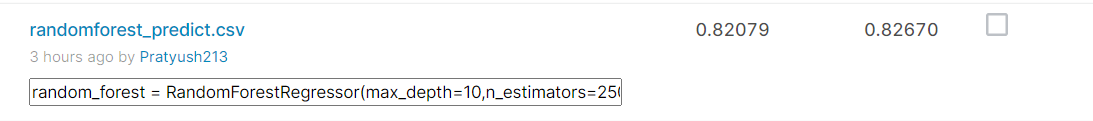
## Score : 0.82670 (kaggle)

2. Decision Tree Regressor

In [37]:
# Hyperparameter Tuning

from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
depths=[1, 5, 10, 50]
split=[5, 10, 100, 500]

tr_error=[]
cross_error=[]

for i in tqdm(depths):
    for j in tqdm(split):
        decision_tree = DecisionTreeRegressor(max_depth=i,min_samples_split=j)
        decision_tree.fit(X_train,y_train)
        
        tr_preds = decision_tree.predict(X_train)
        cv_preds = decision_tree.predict(X_cv)
               
        train_error=0        
        cv_error=0          
    
        train_error=root_mean_squared_logarithmic_error(cv_preds,y_cv) 
        cv_error=root_mean_squared_logarithmic_error(tr_preds,y_train)
        
        tr_error.append(train_error)
        cross_error.append(cv_error) 

100%|██████████| 4/4 [00:30<00:00,  7.75s/it]


In [38]:
# creating a 3D plot of depth, split and errors

# code taken from assignment instructions


x1 = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50]
y1 = [5,10,100,500,5,10,100,500,5,10,100,500,5,10,100,500]
z1 = tr_error

x2 = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50]
y2 = [5,10,100,500,5,10,100,500,5,10,100,500,5,10,100,500]
z2 = cross_error

trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'Train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1,trace2]
layout = go.Layout(scene = dict(
                               xaxis = dict(title='depth'),
                               yaxis = dict(title='split'),
                               zaxis = dict(title='RMLSE'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

In [39]:
# Best parameter depth=10  split=500

from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=10,min_samples_split=500,random_state=None,max_leaf_nodes=31)
decision_tree.fit(X_train,y_train)

tr_preds=decision_tree.predict(X_train)
cv_preds=decision_tree.predict(X_cv)               

train_error=0
cv_error=0  
    
train_error=root_mean_squared_logarithmic_error(cv_preds,y_cv) 
cv_error=root_mean_squared_logarithmic_error(tr_preds,y_train)

In [40]:
print(train_error)
print(cv_error)

0.8049337664728409
0.8054924127378962


In [41]:
decision_predict=decision_tree.predict(test)

In [60]:
sample_submission['visitors']=decision_predict

In [61]:
sample_submission.head()

id   visitors
0  air_00a91d42b08b08d9_2017-04-23  20.967422
1  air_00a91d42b08b08d9_2017-04-24  21.554902
2  air_00a91d42b08b08d9_2017-04-25  21.554902
3  air_00a91d42b08b08d9_2017-04-26  21.554902
4  air_00a91d42b08b08d9_2017-04-27  21.554902

In [62]:
sample_submission.to_csv("decision_tree_predict.csv",index=False)

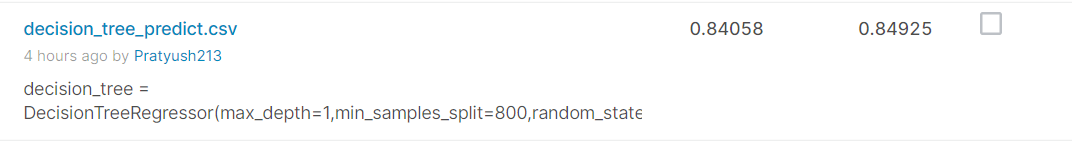
## Score : 0.84925 (kaggle)

3. LGBMRegressor

In [42]:
# I kept no limit to max_depth so that the tree can grow as much as possible.
# Parameters : default
# learning rate=0.1

import lightgbm as lgb

lgb = lgb.LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.1, 
                        n_estimators=100, colsample_bytree=1.0,random_state=None, 
                        n_jobs=-1)
lgb.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
tr_preds=lgb.predict(X_train)
cv_preds=lgb.predict(X_cv)
        
train_error=0
cv_error=0  
    
train_error=root_mean_squared_logarithmic_error(cv_preds,y_cv) 
cv_error=root_mean_squared_logarithmic_error(tr_preds,y_train)

In [44]:
print(train_error)
print(cv_error)

0.6778274320729397
0.6783979462800722


In [45]:
lgb_preds=lgb.predict(test)

In [63]:
sample_submission['visitors']=lgb_preds

In [64]:
sample_submission.head()

id   visitors
0  air_00a91d42b08b08d9_2017-04-23  11.804675
1  air_00a91d42b08b08d9_2017-04-24  15.106869
2  air_00a91d42b08b08d9_2017-04-25  15.243661
3  air_00a91d42b08b08d9_2017-04-26  16.300756
4  air_00a91d42b08b08d9_2017-04-27  16.300756

In [66]:
sample_submission.to_csv("lgb_predict.csv",index=False)

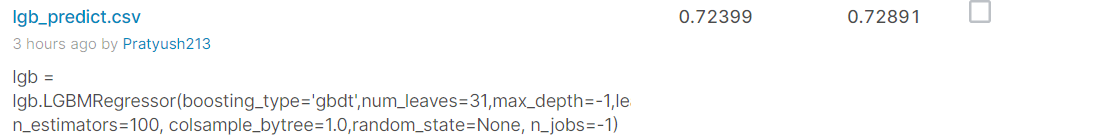
## Score : 0.72891 (kaggle) 

Ensemble Models

In [48]:
ensemble_pred=(r_predict+decision_predict+lgb_preds)/3

In [51]:
sample_submission.to_csv("ensemble_predict.csv",index=False)

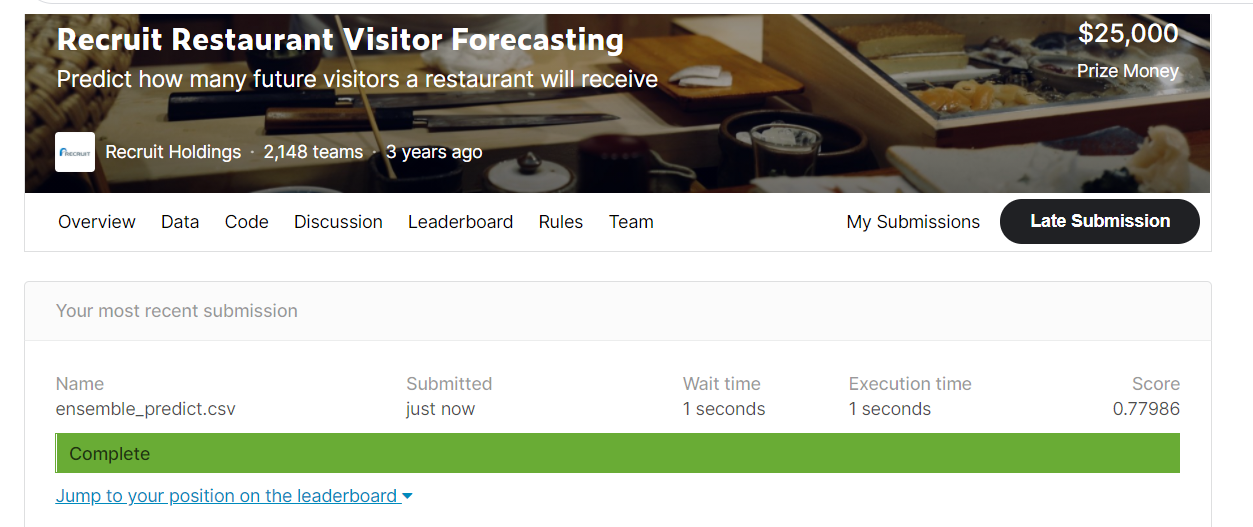

In [52]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=[ "Model", "Depth","Estimator", "Score(Kaggle)"]
x.add_row(["Dummy Model", "-","-","0.85941"])
x.add_row(["RandomForestRegressor", "10","250", "0.82650"])
x.add_row(["DecisionTreeRegressor", "1","500", "0.84925"])
x.add_row(["LGBMRegressor", "-1","100", "0.72891"])
x.add_row(["Ensemble", "-","-", "0.77986"])

print(x)

+-----------------------+-------+-----------+---------------+
|         Model         | Depth | Estimator | Score(Kaggle) |
+-----------------------+-------+-----------+---------------+
|      Dummy Model      |   -   |     -     |    0.85941    |
| RandomForestRegressor |   10  |    250    |    0.82650    |
| DecisionTreeRegressor |   1   |    500    |    0.84925    |
|     LGBMRegressor     |   -1  |    100    |    0.72891    |
|        Ensemble       |   -   |     -     |    0.77986    |
+-----------------------+-------+-----------+---------------+


### Here, I have tried to merge all the restaurants i.e. "air_store_info.csv" and "hpg_stor_info.csv" and plot it into map

In [74]:
rep_hpg_store_info=pd.read_csv('hpg_store_info.csv')
rep_hpg_store_info.head()

hpg_store_id  hpg_genre_name                  hpg_area_name  \
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
1  hpg_e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
2  hpg_2976f7acb4b3a3bc  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
3  hpg_e51a522e098f024c  Japanese style  Tōkyō-to Setagaya-ku Taishidō   
4  hpg_e3d0e1519894f275  Japanese style  Tōkyō-to Setagaya-ku Taishidō   

    latitude   longitude  
0  35.643675  139.668221  
1  35.643675  139.668221  
2  35.643675  139.668221  
3  35.643675  139.668221  
4  35.643675  139.668221

### Excluding the "air_" and "hpg_" part of the restaurant ids so as to concatenate it.

In [75]:
for i in range(len(rep_hpg_store_info)):
    rep_hpg_store_info['hpg_store_id'][i]=rep_hpg_store_info['hpg_store_id'][i][4:]

C:\Users\praty\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [76]:
rep_hpg_store_info=rep_hpg_store_info.rename(columns={"hpg_store_id": "store_id","hpg_genre_name":"genre_name","hpg_area_name":"area_name"})

In [77]:
rep_hpg_store_info.head()

store_id      genre_name                      area_name   latitude  \
0  6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675   
1  e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675   
2  2976f7acb4b3a3bc  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675   
3  e51a522e098f024c  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675   
4  e3d0e1519894f275  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675   

    longitude  
0  139.668221  
1  139.668221  
2  139.668221  
3  139.668221  
4  139.668221

In [78]:
rep_air_store_info=pd.read_csv('air_store_info.csv')
rep_air_store_info.head()


air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
2  air_fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
3  air_a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
4  air_83db5aff8f50478e  Italian/French  Tōkyō-to Minato-ku Shibakōen   

    latitude   longitude  
0  34.695124  135.197852  
1  34.695124  135.197852  
2  34.695124  135.197852  
3  34.695124  135.197852  
4  35.658068  139.751599

In [79]:
for i in range(len(rep_air_store_info)):
    rep_air_store_info['air_store_id'][i]=rep_air_store_info['air_store_id'][i][4:]

C:\Users\praty\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [80]:
rep_air_store_info.head()

air_store_id  air_genre_name                 air_area_name   latitude  \
0  0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
1  7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
2  fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
3  a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
4  83db5aff8f50478e  Italian/French  Tōkyō-to Minato-ku Shibakōen  35.658068   

    longitude  
0  135.197852  
1  135.197852  
2  135.197852  
3  135.197852  
4  139.751599

In [81]:
rep_air_store_info=rep_air_store_info.rename(columns={"air_store_id": "store_id","air_genre_name":"genre_name","air_area_name":"area_name"})

In [82]:
rep_air_store_info.head()

store_id      genre_name                     area_name   latitude  \
0  0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
1  7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
2  fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
3  a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124   
4  83db5aff8f50478e  Italian/French  Tōkyō-to Minato-ku Shibakōen  35.658068   

    longitude  
0  135.197852  
1  135.197852  
2  135.197852  
3  135.197852  
4  139.751599

In [83]:
# cancatenating the restaurants from both the datasets
merge_all_restaurants=[rep_hpg_store_info,rep_air_store_info]
merge_all_restaurants=pd.concat(merge_all_restaurants,axis=0)


In [84]:
merge_all_restaurants.to_csv("merge_all_restaurants.csv",index=False)

In [85]:
merge_all_restaurants=pd.read_csv("merge_all_restaurants.csv")

In [86]:
merge_all_restaurants.head()

store_id      genre_name                      area_name   latitude  \
0  6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675   
1  e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675   
2  2976f7acb4b3a3bc  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675   
3  e51a522e098f024c  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675   
4  e3d0e1519894f275  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675   

    longitude  
0  139.668221  
1  139.668221  
2  139.668221  
3  139.668221  
4  139.668221

In [87]:
# https://plotly.com/python/mapbox-density-heatmaps/
# for all restaurants.

fig = px.density_mapbox(merge_all_restaurants, lat=merge_all_restaurants['latitude'], lon=merge_all_restaurants['longitude'], radius=5,
                        center=dict(lat=36.2048, lon=138.2529), zoom=2,
                        mapbox_style="stamen-terrain")
fig.show()